# Graphical Models

$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
$

In this lab, we implement a Markov Random Field to denoise a binary image. 

| | |
|--|--|
| **Names** | *Thomas Brus & Jan Ubbo van Baardewijk* |
| **Group** | *ML_HMI_01* |


-1 1


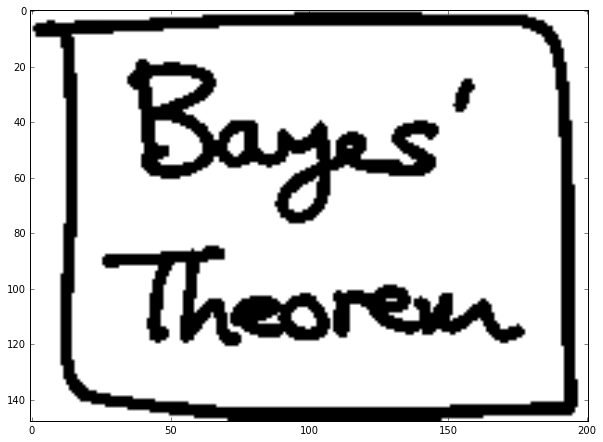

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.ndimage as ndim
import matplotlib.pyplot as plt
import operator
import pylab

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Read in the data:
im = ndim.imread("figure.png")[3:-3,3:-3]-1 # Remove the bor
im = -(-1 + 2*im)

print im.min(), im.max()
plt.imshow(im,cmap="bone")

def corrupt(im,pFlip = 50):  # Flip one in [pFlip] pixels 
    for r in range(im.shape[0]):
        for c in range(im.shape[1]):
            if np.random.randint(pFlip)==0:
                im[r,c] = -im[r,c]


## Markov Random Fields


We do this by iteratively minimizing the energy function defined below. 

Note that the image as it has been loaded above is in the form of a matrix, which allows us to keep track of neighbouring pixels.

So, first of all, we corrupt our image with 20% noise. You can change this amount later, and play with different levels of noise.

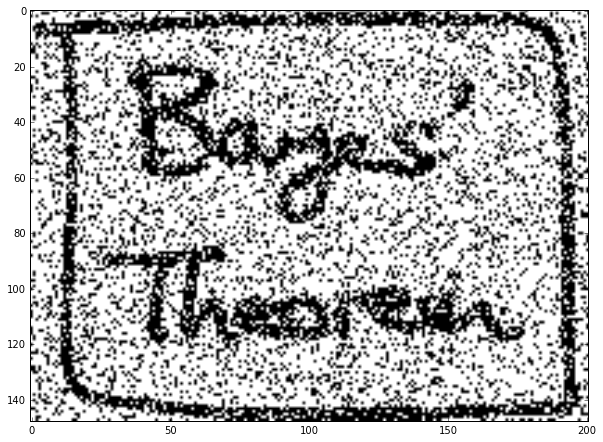

In [3]:
# This code is given

X = im.copy()
corrupt(X, 5)
plt.imshow(X, cmap="bone")

## Defining the energy function

The energy function of the original image $\y$ and the reconstructed image $\x$ is given by

$$
E(\x,\y) = h\sum_i x_i -\beta \sum_{i,j\in \mathrm{ne}(i)} x_i x_j - \eta\sum_i x_iy_i
$$

where the sum over all pixels $i$ and neighobours $j$ of $i$. Notice that in this notation, the images are considered as vectors, while in the implementation we see them as matrices to make looking at neighbouring pixels easier.

**Question 1 [5 marks]** Implement a function `energy(h,beta,eta,x,y)` that computes the energy of the model, for a given set of parameters $h,\beta,\eta$ and image and reconstruction matrices $\x, \y$.

In [12]:
# Answer to Q1
def energy(h, beta, eta, x, y):
    bias = sum(x.flat)
    
    clique1 = 0

    for i in xrange(x.shape[0]):
        for j in xrange(x.shape[1]):
            if i > 0: clique1 += x[i,j] * x[i-1, j]
            if i < x.shape[0] - 1: clique1 += x[i,j] * x[i+1, j]
            if j > 0: clique1 += x[i,j] * x[i, j-1]
            if j < x.shape[1] - 1: clique1 += x[i,j] * x[i, j+1]
    
    clique2 = sum([xi * yi for xi, yi in zip(x.flat, y.flat)])
    
    return h * bias - beta * clique1 - eta * clique2

# Example
print energy(1.0, 1.0, 1.0, X, X)

-58216.0


The energy defined above allows us to compute the change in energy resulting from flipping a single pixel. The function `deltaE` defined below provides us with this computation. 

**Question 2 [5 marks]** What is the computational complexity of this function, in terms of the number of pixels in the image?

**Answer** Effectively, the algorithm loops through all pictures three times. In the second loop the neighbours are also considered but the number of neighbours is constant (max 4), and matrix lookup has O(1) time complexity. Thus the answer is O(N) = 3N

In [29]:
# Answer to Q2
# O(N) = 3N

In [5]:
# This code is given

def deltaE(h, beta, eta, X, Y, r, c):
    v = X[r, c]
    X[r, c] = -v
    E = energy(h, beta, eta, X, Y)
    X[r, c] = v
    return E - energy(h, beta, eta, X, Y)
    


**Question 3 [5 marks]** Can you figure out a more efficient way of implementing `deltaE`? What is the computational complexity of your solution?

**Answer** A more efficient implementation would use the energy function with a version of X and Y that only contain the neighbours of the pixel (r, c). These matrices would be of size 3x3. It is uneccessary to consider the whole matrix since the only change (delta) that occurs is in and around the pixel itself. The time complexity would still be linear to the number of pixels.


In [20]:
# Answer to Q3
Y = X.copy()

print deltaE(1.0, 1.0, 1.0, X, Y, 50, 50)

def myDeltaE(h, beta, eta, X, Y, r, c):
    v = X[r, c]
    X[r, c] = -v
    E = energy(h, beta, eta, X[r-1:r+2, c-1:c+2], Y[r-1:r+2, c-1:c+2])
    X[r, c] = v
    return E - energy(h, beta, eta, X[r-1:r+2, c-1:c+2], Y[r-1:r+2, c-1:c+2])

print myDeltaE(1.0, 1.0, 1.0, X, Y, 50, 50)

-8.0
-8.0


**Question 4 [5 marks]** Implement repeatedly iterating through all the pixels of the image, and flipping the pixels of the reconstruction $\y$ if that change results in a negative deltaE. 

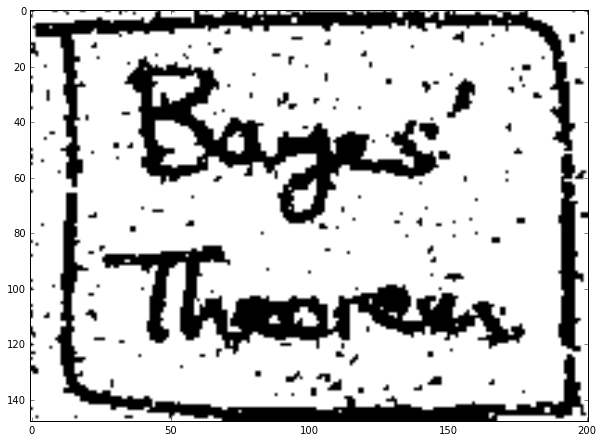

In [45]:
# Answer to Q4

h = 0.2
beta = 0.88
eta = 0.2
Y = X.copy()

for r in xrange(X.shape[0]):
    for c in xrange(X.shape[1]):
        if myDeltaE(h, beta, eta, Y, X, r, c) < 0:
            Y[r, c] = -Y[r, c]

plt.imshow(Y, cmap="bone")

**Question 5 [5 marks]** What is the computational complexity of the complete algorithm, with the original implementation of `deltaE`, and with your new implementation?

**Answer to Q5** The complete algorithm loops through all pixels (N) and uses the delta function once for each of them. The complexity of the delta function is 2 times the complexity of the energy function on N pixels, so 2 \* 3N. (3N => see answer to Q2). This multiplied by N (from Q4) gives N * 6N = 6N^2.

Using the new delta function the energy function loops over a constant number of pixels (9), so it's complexity is constant: O(1). This gives 2 * 1 and the total complexity is N * 1 * 2 = 2N.

**Question 6 [20 marks]** From the original image, can you decide on the optimal values for $h$, $\beta$ and $\eta$? Explain your thought process, and what you can tell from knowing the original image. 

**Answer to Q6**

We will first think about what the different parameters mean. The first parameter, $h$, is the bias. It indicates the ratio of black and white pixels. This can be deduced from the original image.

Next, $\beta$ influences the first clique, i.e. the clique with $x_i$ and its neighbours $x_j$. The higher the value, the more uniform the image is. The lower the value, the more noisy it is. This we can also deduce from the original image.

Finally, $\eta$ corresponds with how much the original image and the corrupted image differ. In our example code we have set the noise ratio to 5%.

**Question 7 [5 marks]** How can you evaluate the quality of the result? Implement your form of evaluation. Use this to evaluate your choice of $h,\beta,\eta$. What are the best values of the parameters you can find? Do they correspond to what you had expected?

**Answer to Q7**

...

In [49]:
from __future__ import division

def evaluate(x, y):
    correspondence = [xi == yi for xi, yi in zip(x.flat, y.flat)]
    return correspondence.count(True) / len(x.flat)

def calculate_black_and_white_ratio(image):
    return [x for x in image.flat].count(1) / len(image.flat)

def calculate_uniformity(image):
    uniformity = 0
        
    for i in xrange(image.shape[0]):
        for j in xrange(image.shape[1]):
            if i > 0 and image[i, j] == image[i-1, j]: uniformity += 1                
            if i < image.shape[0] - 1 and image[i, j] == image[i+1, j]: uniformity += 1                
            if j > 0 and image[i, j] == image[i, j-1]: uniformity += 1                
            if j < image.shape[0] - 1 and image[i, j] == image[i, j+1]: uniformity += 1
    
    return uniformity / (4 * len(image.flat) - 2 * image.shape[0] - 2 * image.shape[1])

print "Quality noisy image", evaluate(X, im)
print "Black & white ratio", calculate_black_and_white_ratio(im)
print "Uniformity", calculate_uniformity(im)
print "Noise", 0.2
print "Quality reconstructed image", evaluate(Y, im)

Quality noisy image 0.801129487697
Black & white ratio 0.791414548877
Uniformity 0.887847228093
Noise 0.2
Quality reconstructed image 0.942786069652
